In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt


2023-12-02 19:36:28.499782: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
img_size = (224,224)
input_shape = (224,224, 3)
batch_size = 32

In [3]:
# CALLBACKS
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40,  # Add rotation
                                   width_shift_range=0.2,  # Horizontal shift
                                   height_shift_range=0.2)  # Vertical shift


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data/train',
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory('data/val',
                                                        target_size=img_size,
                                                        batch_size=batch_size,
                                                        class_mode='binary')

test_generator = test_datagen.flow_from_directory('data/test',
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


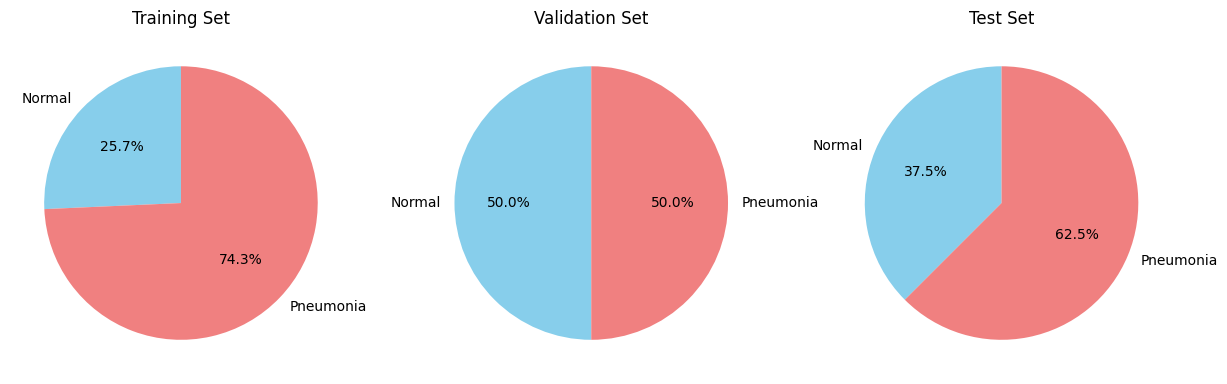

In [5]:
# Count the occurrences of each class in the training set
train_labels = train_generator.classes
train_counts = np.bincount(train_labels)

# Count the occurrences of each class in the validation set
val_labels = validation_generator.classes
val_counts = np.bincount(val_labels)

# Count the occurrences of each class in the test set
test_labels = test_generator.classes
test_counts = np.bincount(test_labels)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Training set pie chart
axs[0].pie(train_counts, labels=['Normal', 'Pneumonia'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
axs[0].set_title('Training Set')

# Validation set pie chart
axs[1].pie(val_counts, labels=['Normal', 'Pneumonia'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
axs[1].set_title('Validation Set')

# Test set pie chart
axs[2].pie(test_counts, labels=['Normal', 'Pneumonia'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
axs[2].set_title('Test Set')
plt.savefig("data_split.png")
plt.show()

In [6]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1, activation='sigmoid'))

# extra
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
# model_checkpoint = ModelCheckpoint('/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.F1Score()])



2023-12-02 19:36:36.583809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46608 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 4008829 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [7]:
# save history to plot
num_epochs = 25
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction]
)


Epoch 1/25


2023-12-02 19:36:53.243235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-02 19:36:56.799588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-02 19:36:58.624363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-02 19:36:58.953817: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbed74e85c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 19:36:58.953869: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-12-02 19:36:59.058435: I tensorflow/compiler/mlir/tensorflow/utils

163/163 [==============================] - 159s 696ms/step - loss: 0.1933 - accuracy: 0.9233 - f1_score: 0.8525 - val_loss: 3.4924 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 2/25
163/163 [==============================] - 109s 666ms/step - loss: 0.1180 - accuracy: 0.9567 - f1_score: 0.8525 - val_loss: 4.1981 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9682 - f1_score: 0.8525
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 108s 662ms/step - loss: 0.0904 - accuracy: 0.9682 - f1_score: 0.8525 - val_loss: 5.2438 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 4/25
163/163 [==============================] - 108s 660ms/step - loss: 0.0610 - accuracy: 0.9801 - f1_score: 0.8525 - val_loss: 1.6550 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - lr: 3.0000e-04
Epoch 5/25
163/163 [===

In [8]:
# test_loss, test_acc = model.evaluate(test_generator, verbose = 1)
score = model.evaluate(test_generator, verbose = 1)
# print(score)
# print("Test loss: ", test_loss)
# print("Test accuracy: ", test_acc)


20/20 [==============================] - 5s 268ms/step - loss: 0.1965 - accuracy: 0.9359 - f1_score: 0.7769
[0.19648398458957672, 0.9358974099159241, array([0.7768924], dtype=float32)]


In [9]:
# if you want to save model
model.save('chest_xray_classifier.keras')
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

OSError: [Errno 30] Read-only file system: '/trainHistoryDict'

### Plots

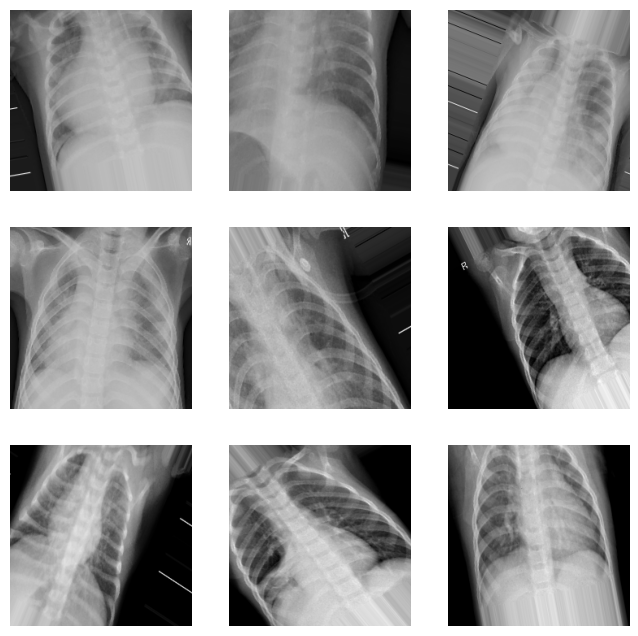

In [10]:
#plot out an augmented image for example

augmented_images, _ = train_generator.next()

plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmented_images[i]
    plt.imshow(augmented_image)
    plt.axis("off")
# plt.savefig("augmented_images.png")
plt.show()


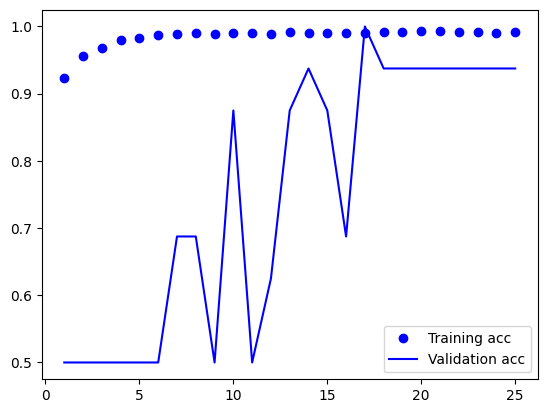

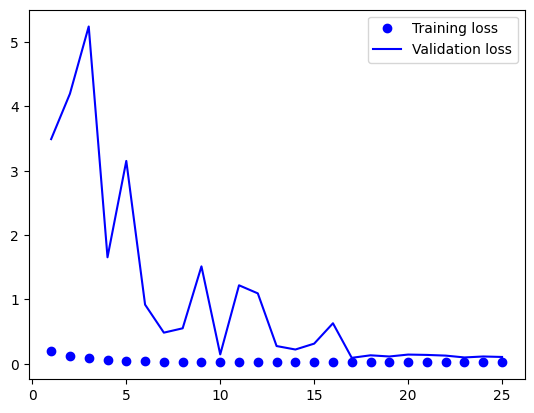

In [11]:
# plot out accuracy and loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
plt.legend()
# plt.ylim(0.6, 0.8)

plt.savefig("acc_plot.png")
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
plt.legend()

plt.savefig("loss_plot.png")
plt.show()

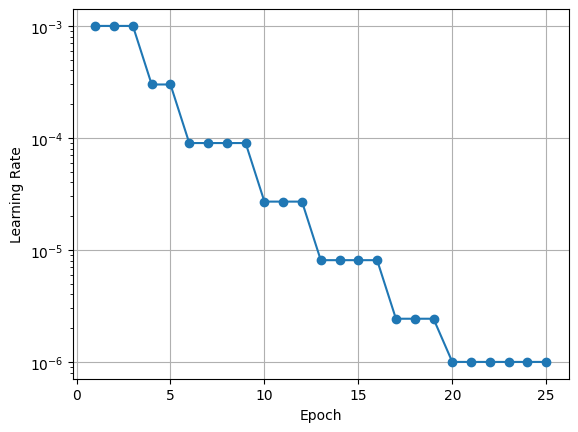

In [12]:
# plot out learning rate over time 
learning_rates = history.history['lr']
epochs = range(1, len(learning_rates) + 1)

# Plot the learning rates over epochs
plt.plot(epochs, learning_rates, marker='o', linestyle='-')
# plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')  # Use a logarithmic scale for better visualization
plt.grid(True)
plt.savefig("lr_plot.png")

plt.show()